In [1]:
import numpy as np
import random as rd

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import src.privacy_ml as ml #import split_horizontally, split_into_random_subsets, stepForward, stepForwardMono, stepForward_2
import src.logistic_reg as lr #import cost
import src.util as util

%load_ext autoreload
%autoreload 2

In [2]:
num_agents = 10
seed = 42

T = 1000
mu = 0.05

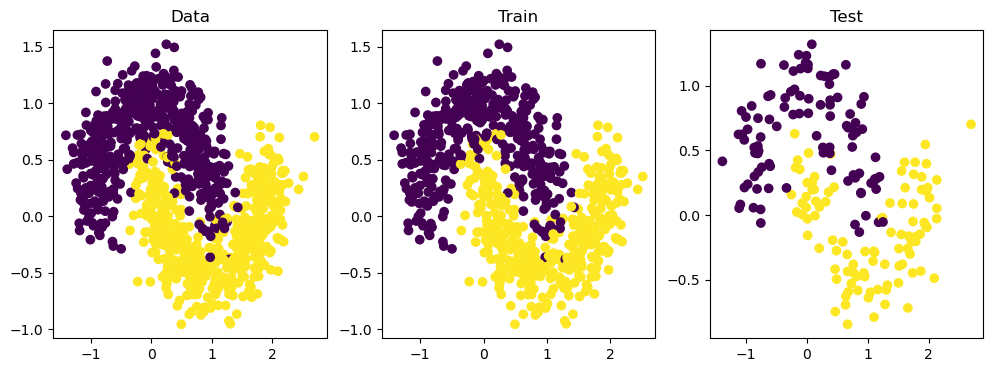

In [3]:
X, Y = make_moons(n_samples=1000, noise=0.2)


Y_formated = OneHotEncoder(categories='auto').fit_transform(Y.reshape(-1,1)).toarray()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=seed, test_size=0.2)
plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
plt.scatter(X[:,0], X[:,1], c=Y)
plt.title("Data")
plt.subplot(1, 3, 2)
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train)
plt.title("Train")
plt.subplot(1, 3, 3)
plt.scatter(X_test[:,0], X_test[:,1], c=Y_test)
plt.title("Test")
plt.show()


On va trier les points par rapport à leur abscisse, pour simuler un effet de proximité entre les points, et utiliser cette proximité pour délimiter les différents agents.

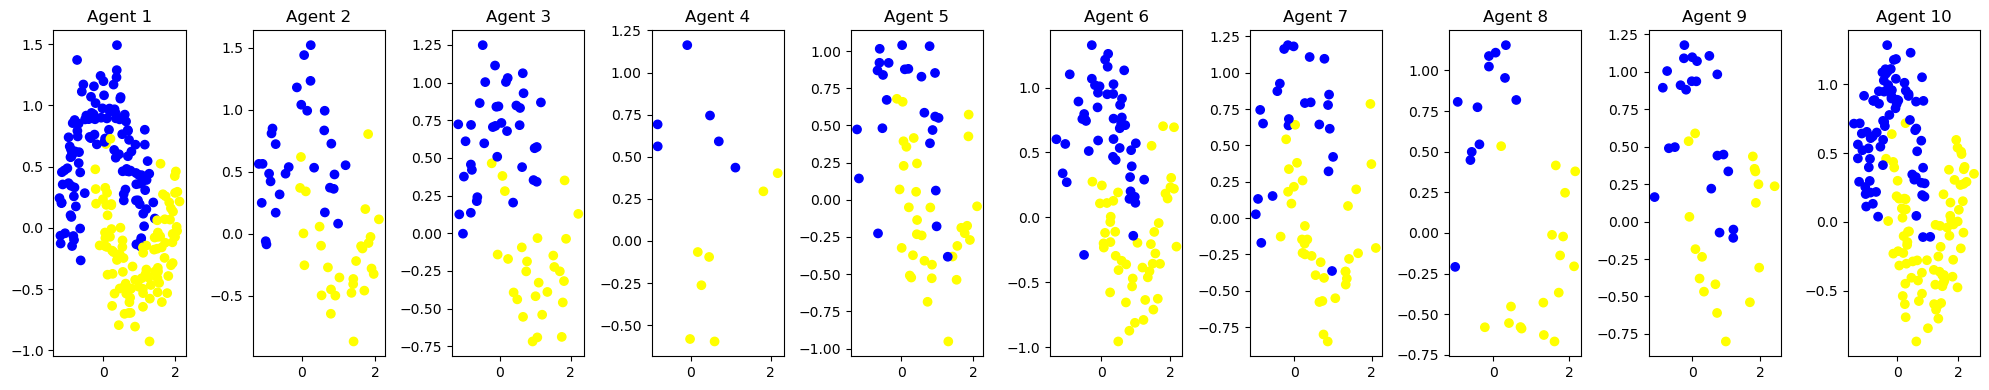

In [4]:

X_agent, Y_agent = ml.split_into_random_subsets(X_train, Y_train)
#X_agent, Y_agent = ml.split_horizontally(X_train, Y_train)


fig, axes = plt.subplots(nrows=1, ncols=num_agents, figsize=(20, 4))

for i in range(num_agents):
    colors = ['blue' if y== 0 else 'yellow' for y in Y_agent[i]]
    axes[i].scatter(X_agent[i][:,0], X_agent[i][:,1], c=colors)
    axes[i].set_title(f'Agent {i+1}')

plt.tight_layout()
plt.show()

In [5]:
X_agent_augmented = []
for i in range(num_agents):
    X_agent_augmented.append(np.concatenate([X_agent[i], X_agent[i]**2, X_agent[i]**3, X_agent[i]**4], axis=1))

In [6]:
X_test_augmented = np.concatenate([X_test, X_test**2, X_test**3, X_test**4], axis=1)
X_train_augmented = np.concatenate([X_train, X_train**2, X_train**3, X_train**4], axis=1)

In [7]:
G = np.zeros((num_agents, num_agents))
for i in range(num_agents):
    for j in range(num_agents):
        if j == i+1 or j == i-1:
            G[i,j] = 1  
    
D = np.zeros(num_agents)
c = np.zeros(num_agents)

maxSize = np.max([x.shape[0] for x in X_agent])
print(f"Max: {maxSize}")
minSize = np.min([x.shape[0] for x in X_agent])
print(f"Min: {minSize}")
meanSize = np.mean([x.shape[0] for x in X_agent])
print(f"Mean: {meanSize}")
for i in range(num_agents):
    D[i] = np.sum(G[i,:])
    c[i] = X_agent[i].shape[0]/maxSize

print(f"G: {G}")
print(f"D: {D}")
print(f"c: {c}")

Max: 225
Min: 13
Mean: 80.0
G: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
D: [1. 2. 2. 2. 2. 2. 2. 2. 2. 1.]
c: [1.         0.25777778 0.28444444 0.05777778 0.25333333 0.41777778
 0.26222222 0.12888889 0.17777778 0.71555556]


## Logistic Regression and Gradient Descent


In linear regression, we got a real-valued response
	
$$\hat{y} = \theta_0 + \theta_1 x_1 + \cdots + \theta_d x_d,$$
    
i.e., a linear combination of inputs, where $\hat{y} \in \mathbf{R}$.

In classification, we want an *indication* of how likely an instance is to belong to a particular class; a probability $\in [0,1]$.  

Given a real valued $z$, we can squish it to range $\sigma(z) \in [0,1]$ by feeding it through the **logistic function** aka **sigmoid function**:
		
\begin{equation}
\sigma(z) = \frac{1}{1+\exp(-z)}. \hspace{1.5cm}(1)
\end{equation}

Which looks like this: ![Sigmoid](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/320px-Logistic-curve.svg.png)

Therefore, we can treat this as a probability, i.e.,

\begin{align*}
P(y=1|\mathbf{x}) &= \sigma(\mathbf{\theta}^\top\mathbf{x}), \\
P(y=0|\mathbf{x}) &= 1 - \sigma(\mathbf{\theta}^\top\mathbf{x}), 
\end{align*}

where we omit the bias term and suppose that both $\mathbf{\theta}$ and $\mathbf{x}$ are column vectors.

In order to chose values for the parameters of logistic regression, we use **maximum likelihood estimation** (MLE). As such we are going to have two steps:

1. write the likelihood function;
2. find the values of $\theta$ that maximize the log-likelihood function.


We begin by defining the design matrix $X \in \mathbb{R}^{n,d}$ containing our data points $x_i^T \in \mathbb{R}^{1\times d}$ on its rows and our column vector of model paramters $\theta \in \mathbb{R}^{d\times 1}.$
The labels that we are predicting are binary, this means that we can interpret each label as a Bernoulli random variable: $Y \sim Ber(p)$ where $p = \sigma(\mathbf{\theta}^\top\mathbf{x})$.

Therefore, we can write the probability of a data point as
$$
P\left(Y=y|X=\mathbf{x}\right) = \sigma(\mathbf{\theta}^\top\mathbf{x})^y \cdot \left[1-\sigma(\mathbf{\theta}^\top\mathbf{x})\right]^{(1-y)}.
$$

Given this probability mass function we can now write the **likelihood** of the whole dataset

\begin{equation}
L(\theta) = \prod_{i=1}^n P(Y = y_i|\mathbf{X} = \mathbf{x}_i) = \prod_{i=1}^n \sigma(\mathbf{\theta}^\top\mathbf{x}_i)^{y_i} \cdot \left[1-\sigma(\mathbf{\theta}^\top\mathbf{x}_i)\right]^{(1-y_i)}. \hspace{1.5cm}(2)
\end{equation}

We can take the log of this function to transform the product into a sum and by doing that, we obtain the **log-likelihood**

\begin{equation}
LL(\theta) = \sum_{i=1}^n \left( y_i\log{\sigma(\mathbf{\theta}^\top\mathbf{x}_i)} + (1-y_i) \log{\left[1-\sigma(\mathbf{\theta}^\top\mathbf{x}_i)\right]} \right). \hspace{1.5cm}(3)
\end{equation}

As you will remember from the first lab, our objective is to minimize the error by fitting our model to the data. However, the log-likelihood increases when the model is fitting better to the data. That's the reason why in logistic regression we take the *negative* log-likelihood (also known as **cost** function $E(\theta)$).

On a : $l(\theta) = - \sum_{i=1}^n \left( y_i\log{\sigma(\mathbf{\theta}^\top\mathbf{x}_i)} + (1-y_i) \log{\left[1-\sigma(\mathbf{\theta}^\top\mathbf{x}_i)\right]} \right).$
donc la dérivée vaut : $\nabla _\theta l(\theta) = -\sum_{i=1}^n y_i (1-\sigma(\theta^Tx_i))x_i - (1-y_i) \sigma(\theta^Tx_i)x_i $

$ \nabla_\theta l(\theta) = -\sum_{i=1}^n (y_i - \sigma(\theta^Tx_i)) x_i $

Besoin du coeff de Lipschitz mais : https://proceedings.neurips.cc/paper_files/paper/2018/file/d54e99a6c03704e95e6965532dec148b-Paper.pdf

Supposons que le sigmoid soit L-lip
Alors 

$ \nabla_\theta l(\theta_0) - \nabla_\theta l(\theta_1)  = -\sum_{i=1}^n (\sigma(\theta_1^Tx_i) - \sigma(\theta_0^Tx_i)) x_i$

$| \nabla_\theta l(\theta_0) - \nabla_\theta l(\theta_1) |_2 \leq \sum_{i=1}^n L|(\theta_1^T - \theta_0^T)x_i| | x_i |_2  \leq \sum_{i=1}^n L|\theta_1^T - \theta_0|_2 |x_i|_2 | x_i |_2 $

Or on a $L = \frac{1}{4} $


## Training

### Single Global Model

In [8]:
np.random.seed(seed)
thetas_mono = np.random.rand(X_train_augmented.shape[1])
costs_train_mono = np.zeros((T))
costs_test_mono = np.zeros((T))

for i in range(T):
    thetas_mono = ml.stepForwardMono(thetas_mono, X_train_augmented, Y_train)
    costs_train_mono[i] = lr.cost(thetas_mono, X_train_augmented, Y_train)
    costs_test_mono[i] = lr.cost(thetas_mono, X_test_augmented, Y_test)
    if i % (T/10) == 0:
                print(f'Iteration {i} : Train: {costs_train_mono[i]:.4f} | Test: {costs_test_mono[i]:.4f}')

# np.random.seed(seed)
# thetas_agents_globalModel = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]

# costs_train_agents_globalModel = np.zeros((T, num_agents))
# costs_test_agents_globalModel = np.zeros((T, num_agents))

# print(T)
# for i in range(T):
#     thetas_agents_globalModel = ml.stepForward(thetas_agents_globalModel, X_agent_augmented, Y_agent, num_agents, 0, c, G, D)
#     for j in range(num_agents):
#             costs_train_agents_globalModel[i,j] = lr.cost(thetas_agents_globalModel[j], X_agent_augmented[j], Y_agent[j])
#             costs_test_agents_globalModel[i,j] = lr.cost(thetas_agents_globalModel[j], X_test_augmented, Y_test)
#     if i % 1000 == 0 :
#         print(f'Iteration {i+1} : Train: {np.mean(costs_train_agents_globalModel[i]):.4f} and {np.std(costs_train_agents_globalModel[i]):.4f} | Test: {np.mean(costs_test_agents_globalModel[i]):.4f} and {np.std(costs_test_agents_globalModel[i]):.4f}')

Iteration 0 : Train: 1.1532 | Test: 1.1208
Iteration 100 : Train: 0.3827 | Test: 0.3937
Iteration 200 : Train: 0.3204 | Test: 0.3344
Iteration 300 : Train: 0.2953 | Test: 0.3104
Iteration 400 : Train: 0.2811 | Test: 0.2969
Iteration 500 : Train: 0.2717 | Test: 0.2881
Iteration 600 : Train: 0.2651 | Test: 0.2819
Iteration 700 : Train: 0.2600 | Test: 0.2772
Iteration 800 : Train: 0.2560 | Test: 0.2735
Iteration 900 : Train: 0.2527 | Test: 0.2705


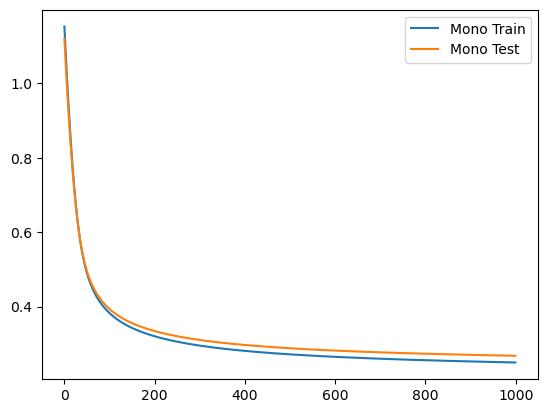

In [9]:
plt.plot(costs_train_mono, label="Mono Train")
plt.plot(costs_test_mono, label="Mono Test")
plt.legend()
plt.show()

# util.plot_curves(num_agents, costs_train_agents_globalModel, costs_test_agents_globalModel, "Multiple Agents")

### Multiple agents

Agents dont share their models (perfectly private baseline)

In [10]:
np.random.seed(seed)
thetas_agents_alone = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]

costs_train_agents_alone = np.zeros((T, num_agents))
costs_test_agents_alone = np.zeros((T, num_agents))

print(T)
for i in range(T):
    thetas_agents_alone = ml.stepForwardAlone(thetas_agents_alone, X_agent_augmented, Y_agent, num_agents, mu, c, G, D)
    for j in range(num_agents):
            costs_train_agents_alone[i,j] = lr.cost(thetas_agents_alone[j], X_agent_augmented[j], Y_agent[j])
            costs_test_agents_alone[i,j] = lr.cost(thetas_agents_alone[j], X_test_augmented, Y_test)
    if i % (T/10) == 0 :
        print(f'Iteration {i} : Train: {np.mean(costs_train_agents_alone[i]):.4f} and {np.std(costs_train_agents_alone[i]):.4f} | Test: {np.mean(costs_test_agents_alone[i]):.4f} and {np.std(costs_test_agents_alone[i]):.4f}')

1000
Iteration 0 : Train: 1.0308 and 0.1928 | Test: 1.0194 and 0.1499
Iteration 100 : Train: 0.3531 and 0.0673 | Test: 0.3881 and 0.0452
Iteration 200 : Train: 0.2963 and 0.0688 | Test: 0.3390 and 0.0381
Iteration 300 : Train: 0.2721 and 0.0718 | Test: 0.3207 and 0.0385
Iteration 400 : Train: 0.2579 and 0.0738 | Test: 0.3111 and 0.0401
Iteration 500 : Train: 0.2481 and 0.0751 | Test: 0.3053 and 0.0421
Iteration 600 : Train: 0.2408 and 0.0759 | Test: 0.3016 and 0.0441
Iteration 700 : Train: 0.2350 and 0.0763 | Test: 0.2991 and 0.0461
Iteration 800 : Train: 0.2303 and 0.0765 | Test: 0.2973 and 0.0480
Iteration 900 : Train: 0.2263 and 0.0766 | Test: 0.2960 and 0.0498


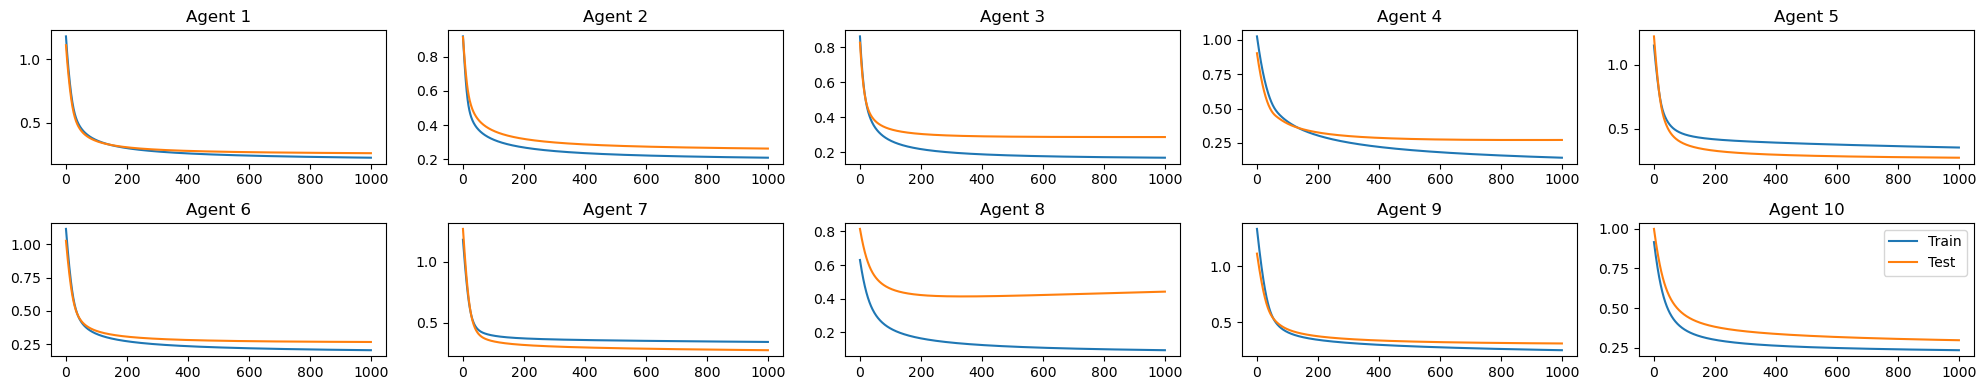

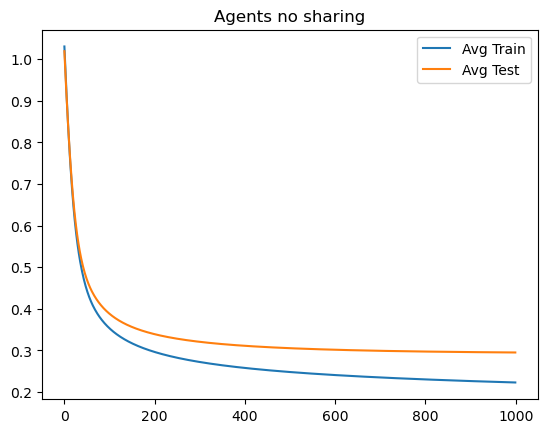

In [11]:
util.plot_curves(num_agents, costs_train_agents_alone, costs_test_agents_alone, "Agents no sharing")

### Multiple agents

All agents do a step after each other in a naive queue and share their models

In [12]:
np.random.seed(seed)
thetas_agents = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]

costs_train_agents = np.zeros((T, num_agents))
costs_test_agents = np.zeros((T, num_agents))

print(T)
for i in range(T):
    thetas_agents = ml.stepForward(thetas_agents, X_agent_augmented, Y_agent, num_agents, mu, c, G, D)
    for j in range(num_agents):
            costs_train_agents[i,j] = lr.cost(thetas_agents[j], X_agent_augmented[j], Y_agent[j])
            costs_test_agents[i,j] = lr.cost(thetas_agents[j], X_test_augmented, Y_test)
    if i % (T/10) == 0 :
        print(f'Iteration {i} : Train: {np.mean(costs_train_agents[i]):.4f} and {np.std(costs_train_agents[i]):.4f} | Test: {np.mean(costs_test_agents[i]):.4f} and {np.std(costs_test_agents[i]):.4f}')

1000
Iteration 0 : Train: 1.0360 and 0.1680 | Test: 1.0246 and 0.1175
Iteration 100 : Train: 0.3616 and 0.0634 | Test: 0.3784 and 0.0273
Iteration 200 : Train: 0.3068 and 0.0679 | Test: 0.3272 and 0.0178
Iteration 300 : Train: 0.2847 and 0.0714 | Test: 0.3064 and 0.0140
Iteration 400 : Train: 0.2721 and 0.0739 | Test: 0.2944 and 0.0114
Iteration 500 : Train: 0.2638 and 0.0758 | Test: 0.2865 and 0.0094
Iteration 600 : Train: 0.2578 and 0.0773 | Test: 0.2807 and 0.0079
Iteration 700 : Train: 0.2533 and 0.0785 | Test: 0.2763 and 0.0067
Iteration 800 : Train: 0.2497 and 0.0795 | Test: 0.2728 and 0.0057
Iteration 900 : Train: 0.2467 and 0.0803 | Test: 0.2700 and 0.0049


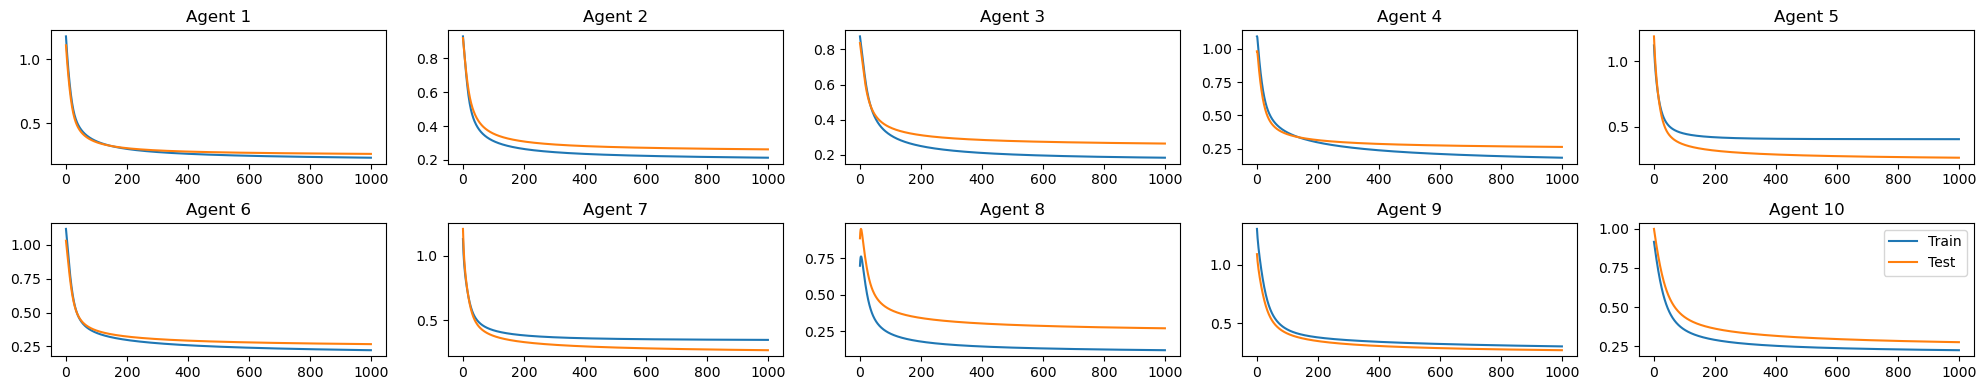

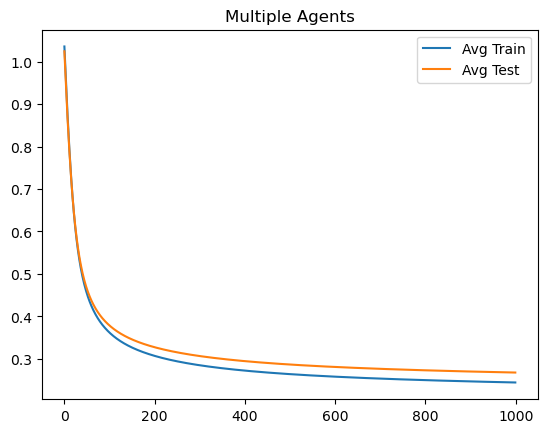

In [13]:
util.plot_curves(num_agents, costs_train_agents, costs_test_agents, "Multiple Agents")

### Random drawing of Agents

randint with global quota

In [14]:
np.random.seed(seed)
tracking  = np.zeros(num_agents) # pour mesurer le nombre de fois que chaque agent passe
total_T = T*num_agents

thetas_agents_rand = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]
costs_test_agents_rand = np.zeros((total_T, num_agents))                 # ici on ne gardera en mémoire que les dernières valeurs
costs_train_agents_rand = np.zeros((total_T, num_agents))


for i in range (total_T) :
    j = rd.randint(0, num_agents-1)
    tracking[j] += 1

    thetas_agents_rand = ml.stepForward_2(thetas_agents_rand, X_agent_augmented, Y_agent, j, num_agents, mu, c, G, D) 

    costs_train_agents_rand[i, j] = lr.cost(thetas_agents_rand[j], X_agent_augmented[j], Y_agent[j])
    costs_test_agents_rand[i, j] = lr.cost(thetas_agents_rand[j], X_test_augmented, Y_test)
        
    if i % ((T/10)*num_agents) == 0 :
        print(f'Iteration {i/num_agents} : Train: {np.mean(costs_train_agents_rand):.4f} and {np.std(costs_train_agents_rand):.4f} | Test: {np.mean(costs_test_agents_rand):.4f} and {np.std(costs_test_agents_rand):.4f}')
       
costs_train_agents_rand = util.reduce_cost_matrix(costs_train_agents_rand)
costs_test_agents_rand = util.reduce_cost_matrix(costs_test_agents_rand)

Iteration 0.0 : Train: 0.0000 and 0.0022 | Test: 0.0000 and 0.0028
Iteration 100.0 : Train: 0.0053 and 0.0566 | Test: 0.0055 and 0.0573
Iteration 200.0 : Train: 0.0087 and 0.0657 | Test: 0.0090 and 0.0669
Iteration 300.0 : Train: 0.0117 and 0.0721 | Test: 0.0122 and 0.0737
Iteration 400.0 : Train: 0.0145 and 0.0773 | Test: 0.0152 and 0.0791
Iteration 500.0 : Train: 0.0172 and 0.0817 | Test: 0.0181 and 0.0838
Iteration 600.0 : Train: 0.0198 and 0.0855 | Test: 0.0209 and 0.0879
Iteration 700.0 : Train: 0.0223 and 0.0888 | Test: 0.0237 and 0.0915
Iteration 800.0 : Train: 0.0248 and 0.0920 | Test: 0.0265 and 0.0949
Iteration 900.0 : Train: 0.0273 and 0.0950 | Test: 0.0292 and 0.0979


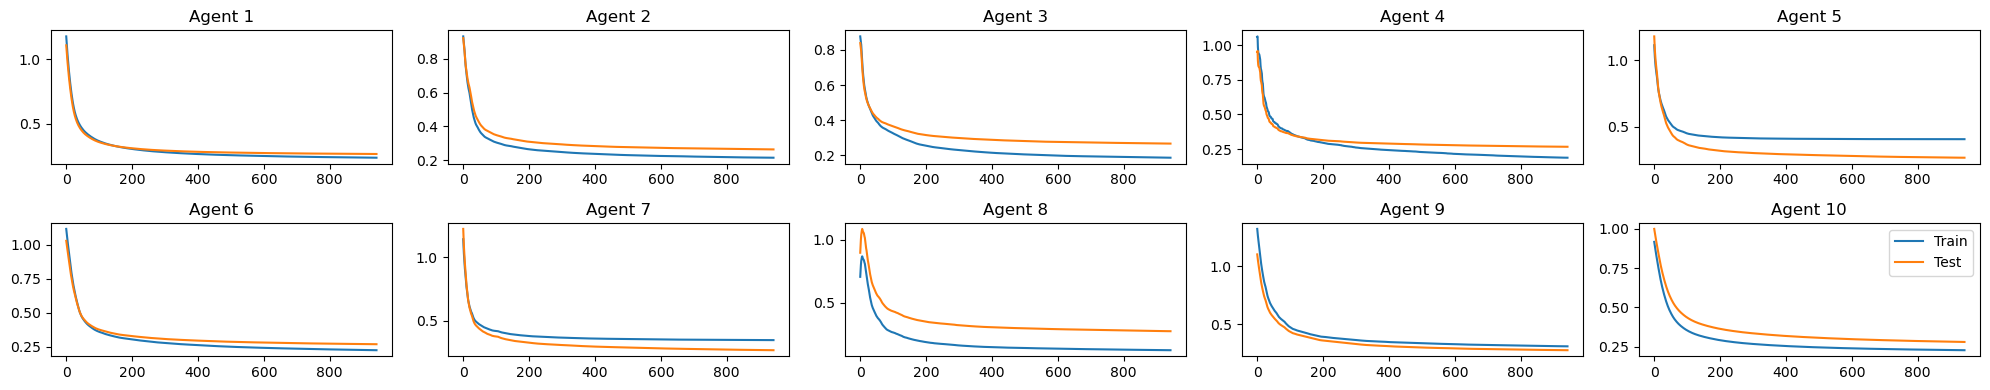

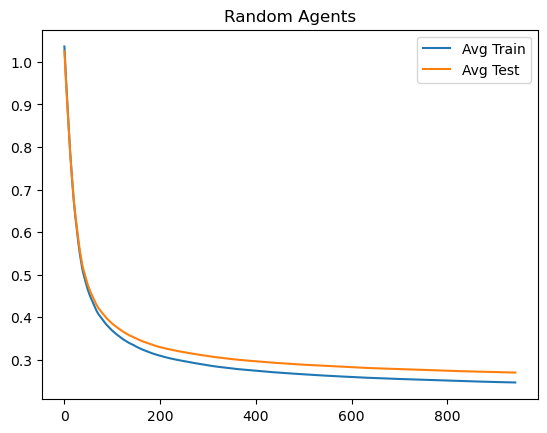

In [15]:
util.plot_curves(num_agents, costs_train_agents_rand, costs_test_agents_rand, "Random Agents")

### Weighting of Agents

In [16]:
np.random.seed(42)
tracking  = np.zeros(num_agents)
total_T = T*num_agents

thetas_agents_weigh = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]
costs_test_agents_weigh = np.zeros((total_T, num_agents))                 # ici on ne gardera en mémoire que les dernières valeurs
costs_train_agents_weigh = np.zeros((total_T, num_agents))



# on obtient les probabilités qu'on veut pour chaque modèle à chaque tirage
coeffs_pond = np.zeros(num_agents)
c_tot = 0
for i in range (len(c)) :
    c_tot += c[i]    
for i in range (len(c)) :
    coeffs_pond[i] = c[i]/c_tot
    
print(coeffs_pond)
print(total_T)

for i in range(total_T) :
    j = np.random.choice(10, 1, p=coeffs_pond)[0]
    tracking[j] += 1

    thetas_agents_weigh = ml.stepForward_2(thetas_agents_weigh, X_agent_augmented, Y_agent, j, num_agents, mu, c, G, D) # y'a probleme

    costs_train_agents_weigh[i, j] = (lr.cost(thetas_agents_weigh[j], X_agent_augmented[j], Y_agent[j]))
    costs_test_agents_weigh[i, j] = (lr.cost(thetas_agents_weigh[j], X_test_augmented, Y_test))
        
    if i % ((T/10)*num_agents) == 0 :
        print(f'Iteration {i/num_agents} : Train: {np.mean(costs_train_agents_weigh):.4f} and {np.std(costs_train_agents_weigh):.4f} | Test: {np.mean(costs_test_agents_weigh):.4f} and {np.std(costs_test_agents_weigh):.4f}')

# costs_train_agents_weigh = util.reduce_cost_matrix(costs_train_agents_weigh)
# costs_test_agents_weigh = util.reduce_cost_matrix(costs_test_agents_weigh)

costs_train_agents_weigh_shifted = util.shift_non_zero_costs_to_front(costs_train_agents_weigh)
costs_test_agents_weigh_shifted = util.shift_non_zero_costs_to_front(costs_test_agents_weigh)

[0.28125 0.0725  0.08    0.01625 0.07125 0.1175  0.07375 0.03625 0.05
 0.20125]
10000
Iteration 0.0 : Train: 0.0000 and 0.0029 | Test: 0.0000 and 0.0032
Iteration 100.0 : Train: 0.0049 and 0.0525 | Test: 0.0051 and 0.0536
Iteration 200.0 : Train: 0.0081 and 0.0615 | Test: 0.0085 and 0.0631
Iteration 300.0 : Train: 0.0110 and 0.0677 | Test: 0.0115 and 0.0698
Iteration 400.0 : Train: 0.0137 and 0.0726 | Test: 0.0145 and 0.0752
Iteration 500.0 : Train: 0.0163 and 0.0767 | Test: 0.0173 and 0.0798
Iteration 600.0 : Train: 0.0188 and 0.0806 | Test: 0.0201 and 0.0839
Iteration 700.0 : Train: 0.0213 and 0.0839 | Test: 0.0228 and 0.0876
Iteration 800.0 : Train: 0.0238 and 0.0872 | Test: 0.0255 and 0.0910
Iteration 900.0 : Train: 0.0263 and 0.0901 | Test: 0.0282 and 0.0941


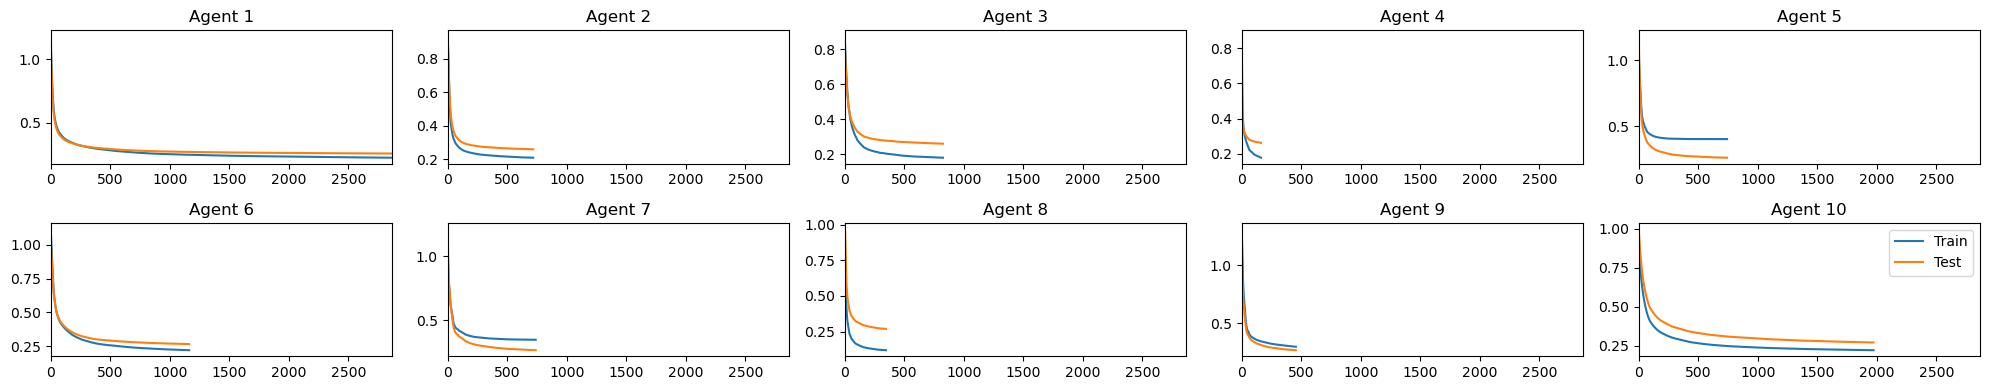

c:\Users\luisw\Studium\TUM RCI\Ecole Polytechnique\First Term\CollaborativeML\Privacy_preserving_ML\src\util.py:51: RuntimeWarning: invalid value encountered in divide
  train_mean = np.sum(costs_train, axis=1) / np.sum(active_mask_train, axis=1)
c:\Users\luisw\Studium\TUM RCI\Ecole Polytechnique\First Term\CollaborativeML\Privacy_preserving_ML\src\util.py:52: RuntimeWarning: invalid value encountered in divide
  test_mean = np.sum(costs_test, axis=1) / np.sum(active_mask_test, axis=1)


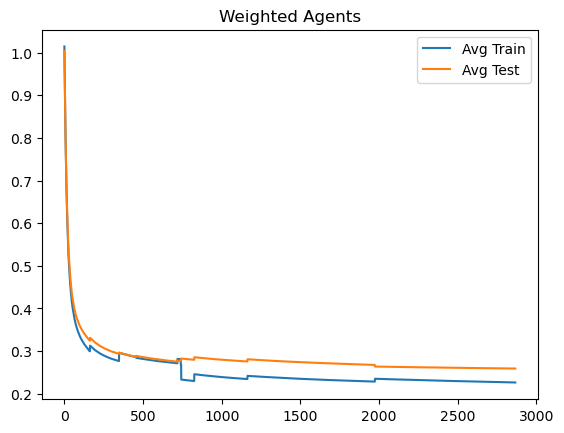

In [17]:
util.plot_curves_non_zero(num_agents, costs_train_agents_weigh_shifted, costs_test_agents_weigh_shifted, "Weighted Agents")

## With Privacy

On fait avec $\delta = 0$ et $\epsilon_i(t_i) = \epsilon$

Si on veut partir du $\bar{\epsilon}$, on va utiliser $\delta$ et $\bar{\delta}$ tous nuls, et utiliser le théorème 1 (et la proposition 2 dans un deuxième temps) pour obtenir des epsilon.


In [18]:
epsilon = 1
L_0 = 0.25

# définit epsilon_barre
epsilon_barre = 3

# technique naïve pour retrouver epsilon : le même à chaque étape

# epsilon = epsilon_barre / T # pour stepForwardPrivate normal

# il faut réestimer le epsilon_barre lorsque le nombre d'étapes d'entraînement pour un modèle n'est pas exactement T 

np.random.seed(42)
thetas_private = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]

costs_train_private = np.zeros(T)
costs_test_private = np.zeros(T)

for i in range(T):
    thetas_private = ml.stepForwardPrivate(thetas_private, X_agent_augmented, Y_agent, num_agents, mu, c, G, D, L_0, epsilon)
    costs_train_private[i] = lr.costDecentralized(thetas_private, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
    costs_test_private[i] = lr.costDecentralized(thetas_private, X_test_augmented, Y_test, num_agents, G, D, c, mu)
    if i % (T/10) == 0 :
        print(f'Iteration {i} : Train: {costs_train_private[i]:.4f} | Test: {costs_test_private[i]:.4f}')

Iteration 0 : Train: 4.3780 | Test: 4.1260
Iteration 100 : Train: 0.1925 | Test: 0.1122
Iteration 200 : Train: 0.1727 | Test: 0.1052
Iteration 300 : Train: 0.1840 | Test: 0.1214
Iteration 400 : Train: 0.1739 | Test: 0.1140
Iteration 500 : Train: 0.1564 | Test: 0.0981
Iteration 600 : Train: 0.1578 | Test: 0.1005
Iteration 700 : Train: 0.1522 | Test: 0.0959
Iteration 800 : Train: 0.1464 | Test: 0.0907
Iteration 900 : Train: 0.1493 | Test: 0.0940


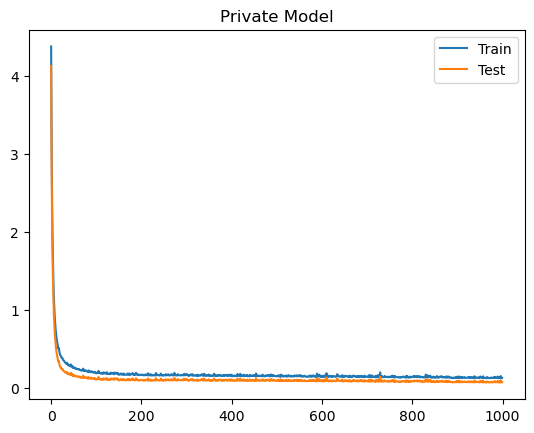

In [19]:
plt.plot(costs_train_private, label="Train")
plt.plot(costs_test_private, label="Test")
plt.title("Private Model")
plt.legend()
plt.show()